## **Link Analysis -Page Rank**

> Project author: Samuel Mesfin Tsegai

Algorithms for Massive Data


*Università degli Studi di Milano*


06-Nov-2023


### **1. Setup and data import**
##### **1.1 Setting up PySpark**


In [1]:
# Get Spark 3.0.3 and Set it Up
!wget -q https://archive.apache.org/dist/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!tar xf spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark

# Set up required environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"



In [2]:
!pip install pyspark==3.0.3 py4j==0.10.9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.1/209.1 MB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 19.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.0.3-py2.py3-none-any.whl size=209435950 sha256=57e384ea216951ca492280aa4537918536cb66d5cc9f152e7d5a2fa0c5d29e4c
  Stored in directory: /root/.cache/pip/wheels/40/50/14/79047c3c171b701e591d287b78a201214d9c8e0b93fef64458
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [3]:
# Initialize SparkSession
from pyspark.sql import SparkSession
import multiprocessing

num_cores = multiprocessing.cpu_count()
spark = SparkSession.builder \
    .appName("Amazon Reviews PageRank") \
    .master(f"local[{num_cores}]") \
    .getOrCreate()


#### **1.2 Import necessary libraries**

In [4]:
# Pyspark imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import collect_list, explode, udf, broadcast
from pyspark.sql.types import ArrayType, StringType, StructType, StructField, FloatType

# Python standard library
from itertools import combinations as it_combinations
from functools import reduce
import matplotlib.pyplot as plt


#### **1.3 importing data**


In [5]:
!pip install --upgrade kaggle
from google.colab import files

# Upload Kaggle API key
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [6]:
import zipfile
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Authenticate with Kaggle API
api = KaggleApi()
api.authenticate()

# Download the dataset
api.dataset_download_files(dataset='cynthiarempel/amazon-us-customer-reviews-dataset')


#### **1.4 Import the selected datasets**
 Load the Datasets
Since these are .tsv files, we'll read them using the PySpark DataFrame API.

    * `amazon_reviews_us_Books_v1_02.tsv`
    * `amazon_reviews_us_Electronics_v1_00.tsv`
    * `amazon_reviews_us_Music_v1_00.tsv`

#### **1.5 Combine selected datasets and Sampling**

In [7]:
# Define the location of the downloaded zip file and the extraction path
zip_path = "/content/amazon-us-customer-reviews-dataset.zip"
extract_path = "/content/amazon/"

# Desired datasets to extract
desired_datasets = [
    "amazon_reviews_us_Books_v1_02.tsv",
    "amazon_reviews_us_Electronics_v1_00.tsv",
    "amazon_reviews_us_Music_v1_00.tsv",
]

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Filter zip file members to match desired datasets
    file_list = [name for name in zip_ref.namelist() if any(dataset in name for dataset in desired_datasets)]

    # Extract the filtered datasets
    zip_ref.extractall(path=extract_path, members=file_list)

# Print the extracted file list
for file_name in file_list:
    print(f"Extracted files: {os.path.join(extract_path, file_name)}")


Extracted files: /content/amazon/amazon_reviews_us_Books_v1_02.tsv
Extracted files: /content/amazon/amazon_reviews_us_Electronics_v1_00.tsv
Extracted files: /content/amazon/amazon_reviews_us_Music_v1_00.tsv


###### Importance of Selected Features:

customer_id: Identifies unique users, vital for tracking individual buying patterns and linking products.

product_id: Essential for determining product nodes in our network.

star_rating: Quantifies user satisfaction, used in weighting connections between products.

verified_purchase: Indicates the authenticity of a review, used as a boost in our link weights.

In [12]:
# Load the datasets using Spark
spark_datasets = [spark.read.csv(os.path.join(extract_path, file_name), sep="\t", header=True) for file_name in file_list]



In [61]:
# for reproducibility and replicability of experiments
import numpy as np
seed_value = 42  # You can use any integer value as the seed
np.random.seed(seed_value)

# Sample each dataset to take 1% of its data.
sampled_datasets = [dataset.sample(False, 0.01, seed=seed_value) for dataset in spark_datasets]


In [62]:

# Unioning the sampled datasets
combined_data = reduce(lambda df1, df2: df1.unionAll(df2), sampled_datasets)

# Select relevant columns and drop duplicates
combined_data = combined_data.select(['customer_id', 'product_id', 'star_rating', 'verified_purchase','product_title','product_category']).dropDuplicates()




#### **1.6 Handling Dead Ends**

In [63]:
# Filter only those customers who have more than 1 review
customer_reviews_count = combined_data.groupby('customer_id').count().withColumnRenamed('count', 'review_count')
combined_data = combined_data.join(broadcast(customer_reviews_count), 'customer_id').filter(customer_reviews_count['review_count'] > 1).drop('review_count')


Given this filtering, there's less chance for a product to be a dead end. Why? Because for a product to appear, it has been reviewed by a customer. And because you're considering only customers with more than one review, it implies that every product appearing in this processed dataset is reviewed by customers who have also reviewed other products. Thus, chances of dead ends are significantly reduced, but not completely eliminated (since there could still be products reviewed by multiple customers where none of those customers reviewed any other products).



In [64]:
combined_data.show(5)

+-----------+----------+-----------+-----------------+--------------------+----------------+
|customer_id|product_id|star_rating|verified_purchase|       product_title|product_category|
+-----------+----------+-----------+-----------------+--------------------+----------------+
|   31898244|1569247757|          4|                N|A Rush of Dreamer...|           Books|
|   37010568|B0002Z0HV0|          5|                N|Stolen Lives: Twe...|           Books|
|   31214014|0743470095|          5|                N|  Little Earthquakes|           Books|
|   47624974|0393314839|          5|                N| The Boston Massacre|           Books|
|   26802692|0415110262|          1|                N|Postmodernism, Ec...|           Books|
+-----------+----------+-----------+-----------------+--------------------+----------------+
only showing top 5 rows



#### **2 Methodological Approach**
The unique twist in our methodology involves weighing connections according to product ratings and their popularity. Additionally, to ensure the credibility of the reviews, i incorporate an added weight (alpha value of 0.5) for products with verified purchases.





---



## Data Exploration

Let's first explore our combined dataset to understand the unique products, customers, and reviews.

---



In [65]:
from pyspark.sql.functions import approx_count_distinct
# Calculate statistics
unique_products = combined_data.select(approx_count_distinct('product_id')).first()[0]
unique_customers = combined_data.select(approx_count_distinct('customer_id')).first()[0]
total_reviews = combined_data.count()

# Print statistics
print(f"number of unique products: {unique_products}")
print(f"number of unique customers: {unique_customers}")
print(f"Total number of reviews: {total_reviews}")

# Persisting the combined data as it is used multiple times
combined_data.persist()


number of unique products: 13879
number of unique customers: 5011
Total number of reviews: 15183


DataFrame[customer_id: string, product_id: string, star_rating: string, verified_purchase: string, product_title: string, product_category: string]

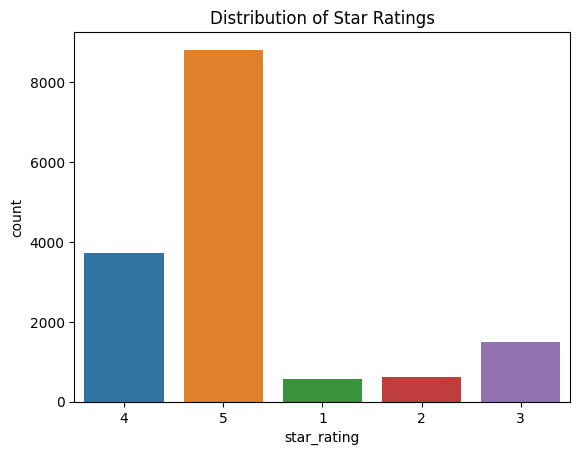

In [66]:
# Distribution of star ratings
import seaborn as sns
sns.countplot(data=combined_data.toPandas(), x='star_rating')
plt.title("Distribution of Star Ratings")
plt.show()



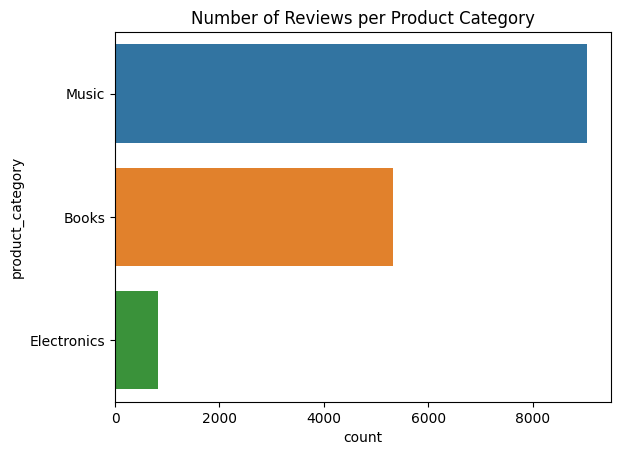

In [67]:
# Plot using Seaborn
sns.countplot(data=combined_data.toPandas(), y='product_category', order=combined_data.toPandas()['product_category'].value_counts().index)
plt.title("Number of Reviews per Product Category")
plt.show()


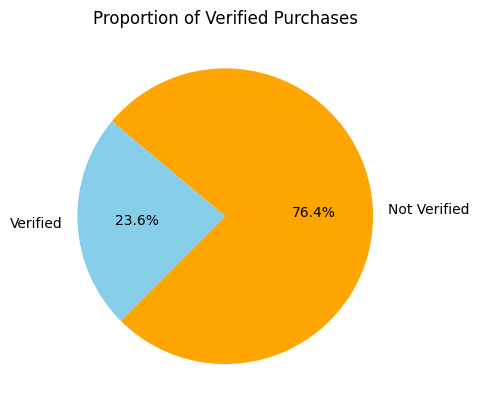

In [68]:
# Filter and group by 'verified_purchase' column
verified_counts = combined_data.filter(combined_data.verified_purchase.isin(['Y', 'N'])).groupBy('verified_purchase').count().collect()

labels = ['Verified' if item[0] == 'Y' else 'Not Verified' for item in verified_counts]
counts = [item[1] for item in verified_counts]

plt.pie(counts, labels=labels, colors=['skyblue', 'orange'], autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Verified Purchases')
plt.show()


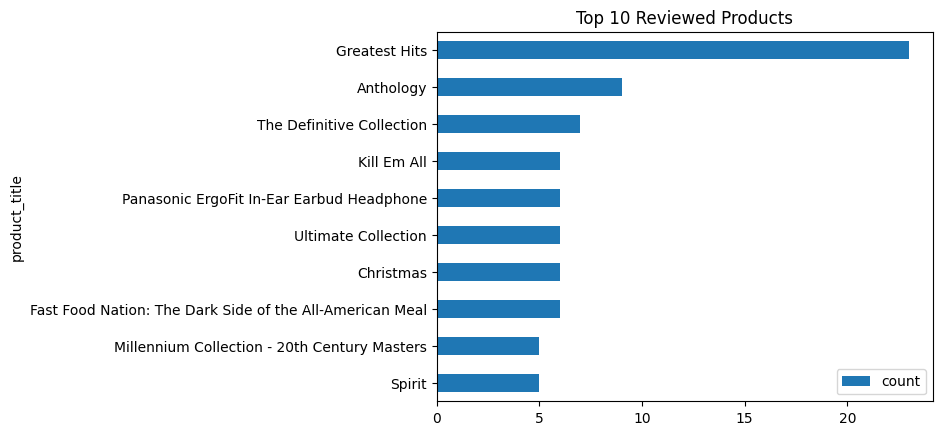

In [69]:

# Top 10 products with the most reviews
top_products = (combined_data
                .groupBy('product_title')
                .agg(F.count('*').alias('count'))
                .orderBy(F.desc('count'))
                .limit(10)
                .toPandas())  # Convert to pandas for plotting

top_products.plot(kind='barh', x='product_title', y='count')
plt.title("Top 10 Reviewed Products")
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()


#### **4.Link Creation and Weight Calculation**


In [70]:
combined_data = combined_data.select('customer_id', 'product_id', 'star_rating', 'verified_purchase')
# Link Creation and Weight Calculation
#Calculate Product Popularity
product_popularity = combined_data.groupBy('product_id').count().withColumnRenamed('count', 'popularity')



##### **4,Building Weighted Product Links Considering Ratings, Verification, and Popularity**
A connection (or link) between two products indicates that they were reviewed by the same customer. But not all connections are equal. Some are stronger due to factors like higher ratings, verification status, or product popularity. So, we’re trying to assign a 'weight' to each connection.


In [71]:
# Integrate Product Popularity into the Weight Calculation
# Integrate Product Popularity into the Weight Calculation
def generate_weighted_product_pairs(products, ratings, verifieds, popularities):
    pairs = []
    for i in range(len(products)):
        for j in range(i+1, len(products)):
            # Add print statements to debug
            print(f"i: {i}, j: {j}")
            print(f"Length of products: {len(products)}, ratings: {len(ratings)}, verifieds: {len(verifieds)}, popularities: {len(popularities)}")

            verified_boost = 0.5 if verifieds[i] == 'Y' and verifieds[j] == 'Y' else 0.0

            # Incorporate popularity into weight, assuming more popular products have higher values
            popularity_boost = (popularities[i] + popularities[j]) / 2.0  # Take average popularity of both products

            weight = (float(ratings[i]) + float(ratings[j])) / 2 + verified_boost + popularity_boost

            pairs.append((products[i], products[j], weight))
            pairs.append((products[j], products[i], weight))  # Reverse for symmetry
    return pairs


weighted_pairs_udf = F.udf(generate_weighted_product_pairs, ArrayType(StructType([
    StructField('product_A', StringType()),
    StructField('product_B', StringType()),
    StructField('weight', FloatType())
])))



In [72]:
# Add product popularity to the combined_data
combined_data = combined_data.join(product_popularity, 'product_id')

# Then use the UDF
review_grouped_df = combined_data.groupby('customer_id').agg(
    F.collect_list('product_id').alias('product_ids'),
    F.collect_list('star_rating').alias('ratings'),
    F.collect_list('verified_purchase').alias('verifieds'),
    F.collect_list('popularity').alias('popularities')  # Collect popularity data
)

links_df = review_grouped_df.withColumn('product_pairs', weighted_pairs_udf('product_ids', 'ratings', 'verifieds', 'popularities'))
links_df = links_df.select(F.explode('product_pairs').alias('product_pair')).select('product_pair.*')



In [73]:
print("Schema of links_df:")
links_df.printSchema()

print("Sample rows of links_df:")
links_df.show(10)


Schema of links_df:
root
 |-- product_A: string (nullable = true)
 |-- product_B: string (nullable = true)
 |-- weight: float (nullable = true)

Sample rows of links_df:
+----------+----------+------+
| product_A| product_B|weight|
+----------+----------+------+
|0805073396|0375752285|   5.5|
|0375752285|0805073396|   5.5|
|B000FVHKFW|B000005H1Q|   6.0|
|B000005H1Q|B000FVHKFW|   6.0|
|B000FVHKFW|B000002OBK|   5.5|
|B000002OBK|B000FVHKFW|   5.5|
|B000FVHKFW|B0000023TW|   5.5|
|B0000023TW|B000FVHKFW|   5.5|
|B000FVHKFW|B000M02D26|   6.0|
|B000M02D26|B000FVHKFW|   6.0|
+----------+----------+------+
only showing top 10 rows



##### 4.4 Normalization
4. Making the Data More Digestible:
Weights can range from very low to very high. To make them more understandable, we adjust (normalize) them to fall between 0 and 1. This doesn't change the relative importance of the connections but makes the numbers easier to grasp.

In [74]:
# Normalization using Min-Max Scaling
max_weight = links_df.agg(F.max('weight')).first()[0]
min_weight = links_df.agg(F.min('weight')).first()[0]

links_df = links_df.withColumn('normalized_weight', (links_df['weight'] - min_weight) / (max_weight - min_weight))

# Print the count and show top 10 product links with their weights
print(f"Generated {links_df.count()} product links with weights.")
links_df.show(10)


Generated 150418 product links with weights.
+----------+----------+------+------------------+
| product_A| product_B|weight| normalized_weight|
+----------+----------+------+------------------+
|0805073396|0375752285|   5.5|0.4666666666666667|
|0375752285|0805073396|   5.5|0.4666666666666667|
|B000FVHKFW|B000005H1Q|   6.0|0.5333333333333333|
|B000005H1Q|B000FVHKFW|   6.0|0.5333333333333333|
|B000FVHKFW|B000002OBK|   5.5|0.4666666666666667|
|B000002OBK|B000FVHKFW|   5.5|0.4666666666666667|
|B000FVHKFW|B0000023TW|   5.5|0.4666666666666667|
|B0000023TW|B000FVHKFW|   5.5|0.4666666666666667|
|B000FVHKFW|B000M02D26|   6.0|0.5333333333333333|
|B000M02D26|B000FVHKFW|   6.0|0.5333333333333333|
+----------+----------+------+------------------+
only showing top 10 rows



#### **5.Constructing the Transition Matrix**
 The transition matrix tells you the probability of jumping from one product (say, Product A) to another product (Product B). The stronger their connection (or weight), the higher the probability of this move.








In [75]:
# Step 1: Construct Transition Matrix using the normalized weight
total_weight_df = links_df.groupBy('product_A').agg(F.sum('normalized_weight').alias('total_weight'))
transition_matrix = links_df.join(total_weight_df, on='product_A')
transition_matrix = transition_matrix.withColumn('probability', transition_matrix['normalized_weight'] / transition_matrix['total_weight'])
print(f"Step 1: Constructed the transition matrix with {transition_matrix.count()} transitions.")
transition_matrix.show(10)



Step 1: Constructed the transition matrix with 150418 transitions.
+----------+----------+------+-------------------+------------------+--------------------+
| product_A| product_B|weight|  normalized_weight|      total_weight|         probability|
+----------+----------+------+-------------------+------------------+--------------------+
|0060279257|B000BICOO6|   4.5| 0.3333333333333333|0.6666666666666666|                 0.5|
|0060279257|0782124313|   4.5| 0.3333333333333333|0.6666666666666666|                 0.5|
|0151011168|0972429514|   4.0|0.26666666666666666|               1.4|  0.1904761904761905|
|0151011168|0151008124|   4.5| 0.3333333333333333|               1.4|  0.2380952380952381|
|0151011168|0375409440|   5.0|                0.4|               1.4| 0.28571428571428575|
|0151011168|B005FDXZJU|   5.0|                0.4|               1.4| 0.28571428571428575|
|0306812959|0912500972|   6.0| 0.5333333333333333| 131.3999999999997|0.004058853373921876|
|0306812959|0741409399|

In this code, we're constructing a "transition matrix" that captures the probability of moving from one product to another based on their connections and popularity. We first determine the total popularity score for each product by aggregating the weights of all its links. We then compute the probability of transitioning to a specific linked product by dividing the popularity score of that specific link by the product's total popularity score. This matrix offers a structured way to understand and quantify how likely one product is to be associated with or lead to another in the dataset.






In [76]:
# Step 2: PageRank Initialization with Normalization
num_products = transition_matrix.select('product_A').distinct().count()
initial_rank = 1.0 / num_products
ranks = transition_matrix.select('product_A').distinct().withColumn('rank', F.lit(initial_rank))
print(f"Step 2: Initialized PageRank with {num_products} products, each having a rank of {initial_rank}.")



Step 2: Initialized PageRank with 14427 products, each having a rank of 6.931447979482915e-05.


Initialization: PageRank starts by giving each product an equal ranking. To determine this initial value, we first find out the number of distinct products in our transition matrix.
Calculation of Initial Rank: We then take the inverse of this count. So, if we have 1000 products, each product gets an initial score of 1/1000.
Assigning Initial Rank: This initial score is then assigned to every product, preparing it for the iterative PageRank computation.
In simpler terms, imagine if you had ten products and you gave each product a starting point of 10 points. That's what's happening here, just scaled up to the actual number of products in the dataset. This ensures a fair start for every product before the algorithm starts to differentiate between them based on their connections.








In [80]:
# Iterative PageRank Calculation
damping = 0.85
iterations = 10

for i in range(iterations):
    temp = transition_matrix.join(ranks, on='product_A')
    contributions = temp.withColumn('contribution', temp['probability'] * temp['rank'])
    sum_contributions = contributions.groupBy('product_B').agg(F.sum('contribution').alias('new_rank'))
    ranks = sum_contributions.withColumnRenamed('product_B', 'product_A')
    ranks = ranks.withColumn('rank', (1 - damping) * initial_rank + damping * ranks['new_rank'])
    print(f"Step .{i+1}: Iteration {i+1} of PageRank calculation completed.")



Step .1: Iteration 1 of PageRank calculation completed.
Step .2: Iteration 2 of PageRank calculation completed.
Step .3: Iteration 3 of PageRank calculation completed.
Step .4: Iteration 4 of PageRank calculation completed.
Step .5: Iteration 5 of PageRank calculation completed.
Step .6: Iteration 6 of PageRank calculation completed.
Step .7: Iteration 7 of PageRank calculation completed.
Step .8: Iteration 8 of PageRank calculation completed.
Step .9: Iteration 9 of PageRank calculation completed.
Step .10: Iteration 10 of PageRank calculation completed.


Initialization: A damping factor (damping) of 0.85 is set, which is a common value in PageRank to prevent infinite loops and to account for the probability that a user might jump to a random product instead of following the links. We're also defining that we'll run the PageRank calculation for 10 iterations.


#### Analysis the Rersult:


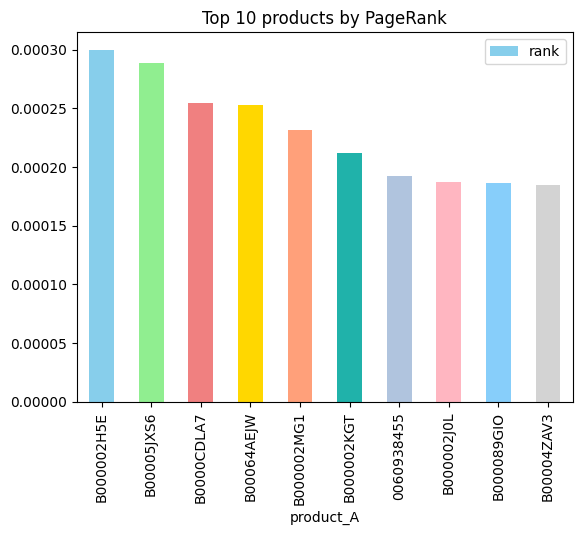

In [81]:
# Results Plot
ranks_pd = ranks.orderBy('rank', ascending=False).limit(10).toPandas()
ax = ranks_pd.plot(kind='bar', x='product_A', y='rank', title='Top 10 products by PageRank', color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'lightsalmon', 'lightseagreen', 'lightsteelblue', 'lightpink', 'lightskyblue', 'lightgray'])
# Display the plot
plt.show()


###Recommendation product to customer
it cab be extended to personal recommendation

In [82]:
def recommend_products_for_customer(customer_id, combined_data, transition_matrix, ranks, num_recommendations=10):
    # Get products the customer has reviewed or purchased
    customer_products = combined_data.filter(combined_data['customer_id'] == customer_id).select('product_id').rdd.flatMap(lambda x: x).collect()

    # Get related products from the transition_matrix
    related_products = transition_matrix.filter(transition_matrix['product_A'].isin(customer_products)).select('product_B').distinct()

    # Join with ranks to get PageRank scores
    related_products_with_ranks = related_products.join(ranks, related_products['product_B'] == ranks['product_A']).select('product_B', 'rank')

    # Get top N recommendations
    top_recommendations = related_products_with_ranks.orderBy('rank', ascending=False).limit(num_recommendations)

    return top_recommendations

customer_id = '31898244'  # replace with actual customer ID
recommendations = recommend_products_for_customer(customer_id, combined_data, transition_matrix, ranks, 10)
recommendations.show()


+----------+--------------------+
| product_B|                rank|
+----------+--------------------+
|B000003N7C|7.449804186580591E-5|
|1569247757|6.928398989840532E-5|
|0822209713|6.416140762027617E-5|
+----------+--------------------+



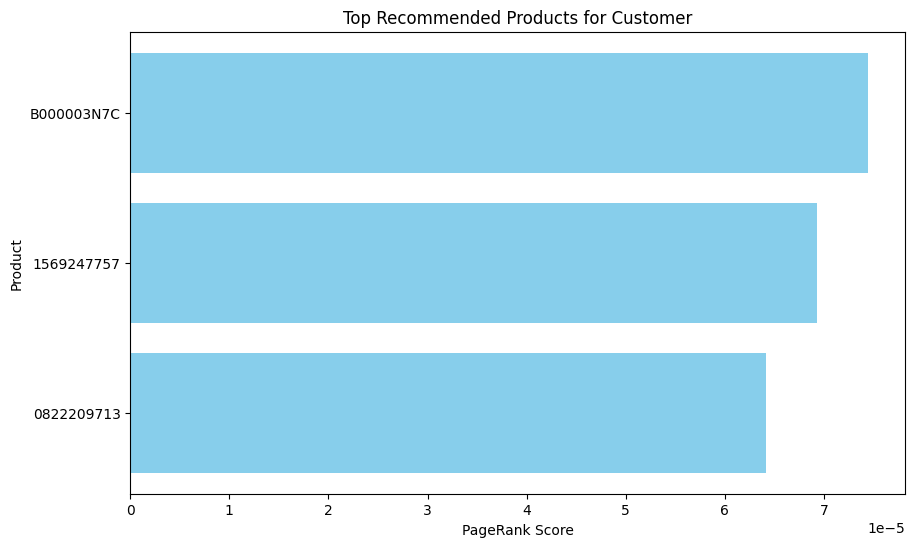

In [83]:
import matplotlib.pyplot as plt

def plot_recommendations(recommendations):
    # Convert the recommendations DataFrame to Pandas
    recommendations_pd = recommendations.toPandas()

    # Plot the recommendations
    plt.figure(figsize=(10, 6))
    plt.barh(recommendations_pd['product_B'], recommendations_pd['rank'], color='skyblue')
    plt.xlabel('PageRank Score')
    plt.ylabel('Product')
    plt.title('Top Recommended Products for Customer')
    plt.gca().invert_yaxis()  # Invert y-axis for better visualization
    plt.show()

# Call the recommend_products_for_customer function and plot the recommendations
customer_id = '31898244'  # replace with an actual customer ID from  dataset
recommendations = recommend_products_for_customer(customer_id, combined_data, transition_matrix, ranks, 10)
plot_recommendations(recommendations)


In [84]:
def recommend_products_for_customer(customer_id, combined_data, transition_matrix, ranks, num_recommendations=10):
    # Get products the customer has reviewed or purchased
    customer_products = combined_data.filter(combined_data['customer_id'] == customer_id).select('product_id').rdd.flatMap(lambda x: x).collect()

    # Get related products from the transition_matrix
    related_products = transition_matrix.filter(transition_matrix['product_A'].isin(customer_products)).select('product_B').distinct()

    # Join with ranks to get PageRank scores
    related_products_with_ranks = related_products.join(ranks, related_products['product_B'] == ranks['product_A']).select('product_B', 'rank')

    # Get top N recommendations
    top_recommendations = related_products_with_ranks.orderBy('rank', ascending=False).limit(num_recommendations)

    return top_recommendations

customer_id = '47624974'  # replace with actual customer ID from your dataset
recommendations1 = recommend_products_for_customer(customer_id, combined_data, transition_matrix, ranks, 10)
recommendations1.show()


+----------+--------------------+
| product_B|                rank|
+----------+--------------------+
|0393314839|7.239915559199223E-5|
|0393319768|7.239915559199223E-5|
|006102063X|6.314512820050297E-5|
+----------+--------------------+



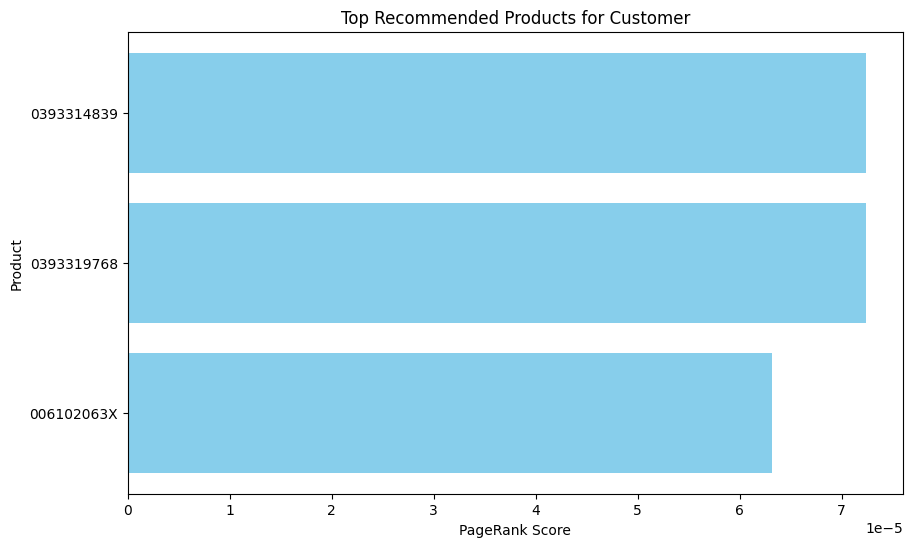

In [85]:
import matplotlib.pyplot as plt

def plot_recommendations(recommendations):
    # Convert the recommendations DataFrame to Pandas
    recommendations_pd = recommendations.toPandas()

    # Plot the recommendations
    plt.figure(figsize=(10, 6))
    plt.barh(recommendations_pd['product_B'], recommendations_pd['rank'], color='skyblue')
    plt.xlabel('PageRank Score')
    plt.ylabel('Product')
    plt.title('Top Recommended Products for Customer')
    plt.gca().invert_yaxis()  # Invert y-axis for better visualization
    plt.show()

# Call the recommend_products_for_customer function and plot the recommendations
customer_id = '47624974'  # replace with an actual customer ID from your dataset
recommendation1s = recommend_products_for_customer(customer_id, combined_data, transition_matrix, ranks, 10)
plot_recommendations(recommendations1)
